# Statistical analysis

### Difference between BERT+ResNet-152 and CLIP versions of models

In [1]:
import scipy as sp
import pandas as pd
import numpy as np
from src.definitions import ROOT_DIR
from pathlib import PurePosixPath
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def plot_dist(
    model1: np.ndarray, model2: np.ndarray, filter_quantiles: float = 0.01, color="blue"
) -> None:
    fig, ax = plt.subplots()
    min_val = np.quantile(model1 - model2, filter_quantiles)
    max_val = np.quantile(model1 - model2, 1 - filter_quantiles)
    ar = model1 - model2
    ar = ar[(min_val < ar) & (ar < max_val)]
    sns.kdeplot(ar, color=color, ax=ax)
    return fig

In [3]:
test_results = pd.DataFrame(columns=["Architecture", "Model 1", "Model 2", "Statistic", "p-value"])
test_results = test_results.set_index(["Architecture", "Model 1", "Model 2"])

##### Simple concatenation

In [4]:
from src.models.bert import FPBERTResNet152ConcatModel
from src.models.clip import FPCLIPConcatModel

# run_01: 61480.37 vs. run_02: 58109.56
simple_bert_resnet152 = FPBERTResNet152ConcatModel.load_from_best_checkpoint(run="run_02")
simple_bert_resnet152.hparams.update({"store_submission_frame": False})
sub_simple_bert_resnet152 = simple_bert_resnet152.make_submission_frame()
del simple_bert_resnet152
res_simple_bert_resnet152 = (
    (sub_simple_bert_resnet152["true"]/100 - sub_simple_bert_resnet152["pred"]/100) ** 2
).values

# run_01: 64375.36 vs. run_02: 63116.73
simple_clip = FPCLIPConcatModel.load_from_best_checkpoint(run="run_02")
simple_clip.hparams.update({"store_submission_frame": False})
sub_simple_clip = simple_clip.make_submission_frame()
del simple_clip
res_simple_clip = (
    (sub_simple_clip["true"]/100 - sub_simple_clip["pred"]/100) ** 2
).values

Global seed set to 42
Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/34 [00:00<?, ?it/s]

Global seed set to 42


  0%|          | 0/34 [00:00<?, ?it/s]

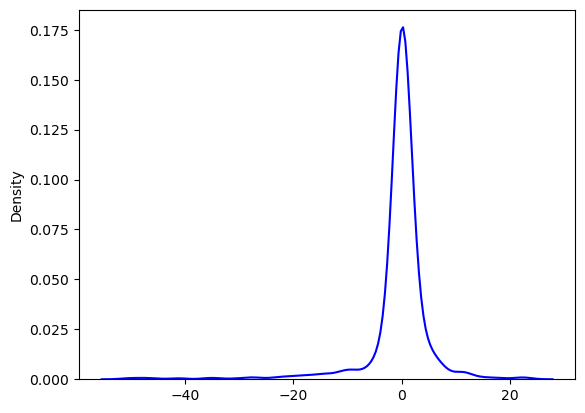

In [5]:
fig = plot_dist(res_simple_bert_resnet152, res_simple_clip)
fig.savefig("plots/density_paired_t-test_simple.jpg")

In [6]:
simple_ttest = sp.stats.ttest_rel(
    a=res_simple_bert_resnet152,
    b=res_simple_clip,
    alternative="greater"
)

# Theory: CLIP better than BERT+ResNet-152
# H0: BertResNet152 <= CLIP
# H1: greater

test_results.loc[("Simple", "Bert + ResNet-152", "CLIP"), :] = (simple_ttest.statistic, simple_ttest.pvalue)

In [7]:
test_results

,,,Statistic,p-value
Architecture,Model 1,Model 2,,
Simple,Bert + ResNet-152,CLIP,-1.79227,0.963312


##### Attention-like mechanism

In [8]:
from src.models.bert import FPBERTResNet152WeightedConcatModel
from src.models.clip import FPCLIPWeightedConcatModel

# run_01: 60493.92 vs. run_02: 56450.27
weighted_bert_resnet152 = FPBERTResNet152WeightedConcatModel.load_from_best_checkpoint(run="run_02")
weighted_bert_resnet152.hparams.update({"store_submission_frame": False})
sub_weighted_bert_resnet152 = weighted_bert_resnet152.make_submission_frame()
del weighted_bert_resnet152
res_weighted_bert_resnet152 = (
    (sub_weighted_bert_resnet152["true"]/100 - sub_weighted_bert_resnet152["pred"]/100) ** 2
).values

# run_01: 61844.27 vs. run_02: 54986.56
weighted_clip = FPCLIPWeightedConcatModel.load_from_best_checkpoint(run="run_02")
weighted_clip.hparams.update({"store_submission_frame": False})
sub_weighted_clip = weighted_clip.make_submission_frame()
del weighted_clip
res_weighted_clip = (
    (sub_weighted_clip["true"]/100 - sub_weighted_clip["pred"]/100) ** 2
).values

Global seed set to 42
Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/34 [00:00<?, ?it/s]

Global seed set to 42


  0%|          | 0/34 [00:00<?, ?it/s]

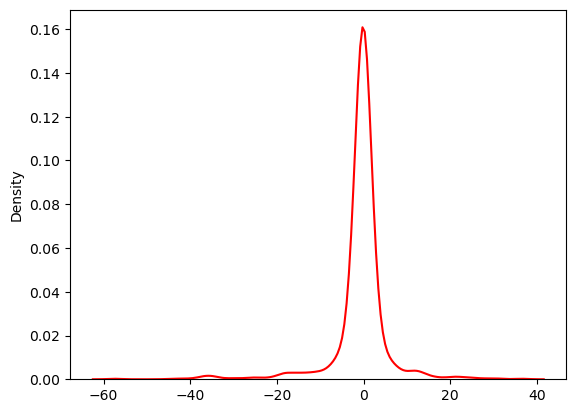

In [9]:
fig = plot_dist(res_weighted_bert_resnet152, res_weighted_clip, color="red")
fig.savefig("plots/density_paired_t-test_weighted.jpg")

In [10]:
weighted_ttest = sp.stats.ttest_rel(
    a=res_weighted_bert_resnet152, b=res_weighted_clip, alternative="greater"
)

# Theory: CLIP better than BERT+ResNet-152
# H0: BertResNet152 <= CLIP
# H1: greater

test_results.loc[("Weighted", "Bert + ResNet-152", "CLIP"), :] = (
    weighted_ttest.statistic,
    weighted_ttest.pvalue,
)

In [11]:
test_results

,,,Statistic,p-value
Architecture,Model 1,Model 2,,
Simple,Bert + ResNet-152,CLIP,-1.79227,0.963312
Weighted,Bert + ResNet-152,CLIP,-2.067062,0.980515


##### XGB

In [12]:
submissions_fpath = PurePosixPath(ROOT_DIR).joinpath(
    "submissions", "2022-08-27T17:04:06+00:00"
)

xgb_bert_resnet152_fname = submissions_fpath.joinpath("XGBBERTResNet152.csv")
sub_xgb_bert_resnet152 = pd.read_csv(xgb_bert_resnet152_fname, index_col=0, header=0)
res_xgb_bert_resnet152 = (
    (sub_xgb_bert_resnet152["true"]/100 - sub_xgb_bert_resnet152["pred"]/100) ** 2
).values

xgb_clip_fname = submissions_fpath.joinpath("XGBCLIP.csv")
sub_xgb_clip = pd.read_csv(xgb_clip_fname, index_col=0, header=0)
res_xgb_clip = ((sub_xgb_clip["true"]/100 - sub_xgb_clip["pred"]/100) ** 2).values

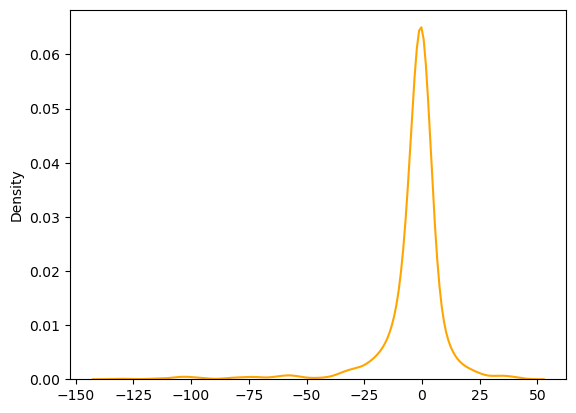

In [13]:
fig = plot_dist(res_xgb_clip, res_xgb_bert_resnet152, color="orange")
fig.savefig("plots/density_paired_t-test_xgb.jpg")

In [14]:
xgb_ttest = sp.stats.ttest_rel(
    a=res_xgb_bert_resnet152,
    b=res_xgb_clip,
    alternative="greater"
)

# Theory: CLIP better than BERT+ResNet-152
# H0: BertResNet152 < CLIP
# H1: greater

test_results.loc[("XGB", "Bert + ResNet-152", "CLIP"), :] = (
    xgb_ttest.statistic,
    xgb_ttest.pvalue,
)

In [15]:
with open("tables/paired_t-tests.tex", mode="w") as f:
    test_results.style.to_latex(f)
test_results.style

,,,Statistic,p-value
Architecture,Model 1,Model 2,,
Simple,Bert + ResNet-152,CLIP,-1.792270,0.963312
Weighted,Bert + ResNet-152,CLIP,-2.067062,0.980515
XGB,Bert + ResNet-152,CLIP,4.791208,0.000001


### Difference between the best model and the respondents to the Bot

In [16]:
data_fpath = PurePosixPath(ROOT_DIR).joinpath("data", "experiment", "merged")

data_fname = data_fpath.joinpath("dump.parquet")

data = pd.read_parquet(data_fname)
data = data[["chat_id", "item_id", "pred", "price_fractional"]].rename(columns={"price_fractional": "true"})
res_humans = ((data["true"]/100 - data["pred"]/100) ** 2).values

res_best_model = res_weighted_clip.astype(np.float64)  # it's the model with the best results on the dev

In [17]:
def plot_separate_dists(model1:np.ndarray, model2:np.ndarray, label1:str, label2:str, filter_quantiles:float=0.01) -> None:
    fig, ax = plt.subplots()
    min_val_1 = np.quantile(model1, filter_quantiles)
    max_val_1 = np.quantile(model1, 1-filter_quantiles)
    min_val_2 = np.quantile(model2, filter_quantiles)
    max_val_2 = np.quantile(model2, 1-filter_quantiles)
    model1 = model1[(min_val_1 < model1) & (model1 < max_val_1)]
    model2 = model2[(min_val_2 < model2) & (model2 < max_val_2)]
    sns.kdeplot(model1, color="green", label=label1, ax=ax)
    sns.kdeplot(model2, color="purple", label=label2, ax=ax)
    plt.legend()
    return fig

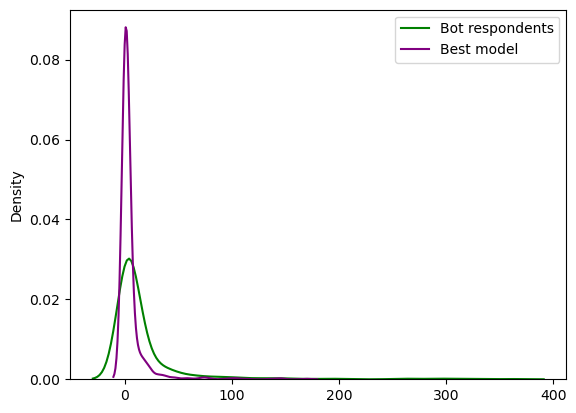

In [18]:
fig = plot_separate_dists(res_humans, res_best_model, "Bot respondents", "Best model")
fig.savefig("plots/density_unpaired_t-test.jpg")

In [19]:
sp.stats.ttest_ind(
    a=res_humans, 
    b=res_best_model,
    equal_var=False,
    alternative="greater"
)

# Theory: model better than humans
# H0: humans <= model
# H1: greater

Ttest_indResult(statistic=3.322848317734092, pvalue=0.0004528173848939469)